In [1]:
import os
from dotenv import load_dotenv
from openai import OpenAI
import yfinance as yf
import numpy as np
import pandas as pd
import json

In [2]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key = api_key)

In [3]:
def get_stock_data(ticker):
    stock = yf.Ticker(ticker)
    history = stock.history(period="7d")
    dates = history.index.strftime("%Y-%m-%d").tolist()
    prices = history["Close"].tolist()

    return dates, prices

In [21]:
def analyze_stock_trend(ticker):
    dates, prices = get_stock_data(ticker)
    
    # 📌 변동성 & 상승/하락 추세 계산
    price_diff = np.diff(prices)
    trend = "상승" if sum(price_diff) > 0 else "하락"
    avg_price = np.mean(prices)
    volatility = np.std(prices)
    
    # 📌 AI에게 전달할 메시지 생성
    messages = [
        {"role": "system", "content": "너는 금융 시장을 분석하는 AI야."},
        {"role": "user", "content": f"{ticker}의 최근 7일간 주가 데이터야. 이를 기반으로 향후 전망을 분석해줘."},
        {"role": "user", "content": f"날짜: {dates}"},
        {"role": "user", "content": f"주가: {prices}"},
        {"role": "user", "content": f"주가 변동 추세: {trend}, 평균 가격: {avg_price:.2f}, 변동성: {volatility:.2f}"}
    ]

    # 📌 OpenAI API 호출
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages
    )
    response_dict = response.to_dict()
    return response_dict["choices"][0]["message"]["content"]

In [22]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "get_stock_price",
            "description": "특정 기업의 현재 주가를 가져옴",
            "parameters": {
                "type": "object",
                "properties": {
                    "ticker": {
                        "type": "string",
                        "description": "주가를 조회할 기업의 주식 코드 (예: AAPL, TSLA, GOOG)",
                    }
                },
                "required": ["ticker"],
            },
        },
    }
]

In [23]:
response = client.chat.completions.create(
    model = "gpt-4o-mini",
    messages = [
        {"role" : "user", "content" : "nvidia의 현재 주가 알려줘"},#role, content 고정
    ],
    tools = tools,
    tool_choice = "auto"
    
)

In [24]:
response_dict = response.to_dict()

# tool_calls가 있는지 확인 후 처리
if "tool_calls" in response_dict["choices"][0]["message"]:
    tool_call = response_dict["choices"][0]["message"]["tool_calls"][0]
    function_name = tool_call["function"]["name"]
    arguments = json.loads(tool_call["function"]["arguments"])

    if function_name == "get_stock_price":
        ticker = arguments["ticker"]
        analysis_result = analyze_stock_trend(ticker)
        print(f"{analysis_result}")

제공된 데이터를 기반으로 NVIDIA(NVDA)의 최근 주가 동향을 분석해보겠습니다.

1. **주가 변동 추세**:
   - 주가는 기간 동안 전반적으로 상승세를 보였습니다. 특히, 3월 12일부터 3월 14일까지 크게 상승한 후 소폭의 조정을 보였습니다.

2. **평균 가격**:
   - 평균 주가는 114.81로 나타났습니다. 이는 최근 7일간의 주가 변동을 고려할 때, 시장의 관심이 높아졌음을 시사합니다. 평균 가격보다 하회하는 날이 많지 않았고, 이는 강한 지지대가 생겼음을 의미합니다.

3. **변동성**:
   - 변동성이 4.92로 적당한 수준입니다. 이는 주가의 급격한 변동 없이 안정적인 상승세가 이어지고 있음을 보여줍니다. 변동성이 낮을수록 투자자들은 더 안정적인 성격을 기대할 수 있습니다.

### 전망
- **단기 전망**: NVDA는 상승세를 유지하고 있으며, 평균 가격인 114.81를 지지선으로 삼고 있을 가능성이 큽니다. 만약 주가가 이 지지선을 하회하지 않는다면, 추가적인 상승이 기대됩니다.
  
- **중기 전망**: 기술적 분석 측면에서 추가적인 상승 여력이 충분하다고 판단됩니다. 최근의 상승세와 낮은 변동성은 긍정적인 투자 심리를 반영하고 있습니다. 그러나, 주가가 급등한 상태이므로 조정이 있을 수 있으니 이 점을 유의해야 합니다.

- **위험 요소**: 반도체 산업 전반의 성장 기조와 함께 경제 지표, 시장 전반의 조건, 경쟁사의 동향 등 외부 요인들이 주가에 영향을 미칠 수 있으므로 지속적인 시장 모니터링이 중요합니다.

결론적으로, NVDA는 현재 긍정적인 추세를 유지하고 있으며, 단기적으로는 추가적인 상승 가능성이 있지만, 시장의 상황에 따라 변동성이 커질 수 있음을 감안해야 합니다.


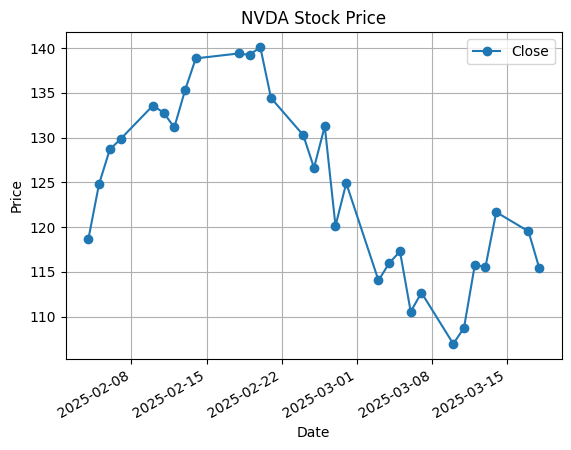

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

result.plot(marker='o')
plt.title(f"{ticker} Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid()